In [37]:
import wfdb
from scipy import signal
import scipy
import numpy as np
from matplotlib import pyplot as plt
import math

In [38]:
from scipy.signal import butter, filtfilt

def butter_bandpass_filter(input_signal, low_cutoff, high_cutoff, sampling_rate, order):
    nyq = 0.5 * sampling_rate
    low = low_cutoff / nyq
    high = high_cutoff / nyq
    numerator, denominator = butter(order, [low, high], btype='band', output='ba', analog=False, fs=None)
    filtered = filtfilt(numerator, denominator, input_signal)
    return filtered

def smoothMAconv(depth,temp, scale): # Moving average by numpy convolution
    dz = np.diff(depth) 
    N = int(scale/dz[0])
    smoothed=np.convolve(temp, np.ones((N,))/N, mode='same') 
    return smoothed

def get_onset_offset(X, Y, signal):
    a_norm = math.sqrt((Y[0]-X[0])**2 + (Y[1]-X[1])**2)
    
    a = np.array([[X[0], X[1]], [Y[0], Y[1]]])

    c_x = X[0]
    prev_sigma_max = -1
    max_x = -1
    while True:
        if X[0] > Y[0]:
            if c_x <= Y[0]:
                return max_x
            c_x -= 1
        else:
            if c_x >= Y[0]:
                return max_x
            c_x += 1
        
        c = np.array([[X[0], X[1]], [c_x, signal[int(c_x)]]])
        
        ac_cross = np.cross(a, c)
        m_cross = (a[0][0]-a[1][0]) * (c[0][1]-c[1][1]) - (a[0][1]-a[1][1]) * (c[0][0]-c[1][0])
        
        ac_norm = np.linalg.norm(ac_cross)
        sigma = ac_norm / a_norm
        if X[0] > Y[0]:
            sigma = m_cross
        else:
            sigma = -m_cross

        if sigma > prev_sigma_max:
            prev_sigma_max = sigma
            max_x = int(c_x)



# Read Record

In [39]:
# TODO: Read all records for patients. Save fiducial features for each record/patient

samp_start = 1300+700
samp_end = 3200+1400
fs = 1000
time = (samp_end - samp_start) / fs
# best start = 1300, best end = 3200
record = wfdb.rdrecord('../01.Dataset/117/s0291lre', channels=[1], sampfrom=samp_start, sampto=samp_end)
yraw = record.p_signal[:, 0]

# Get Fiducial Features

In [40]:
# STEPS 1 to 4

# 1. Bandpass (low pass / high pass)
y_lfiltered = butter_bandpass_filter(record.p_signal[:, 0], low_cutoff=1.0, high_cutoff=40.0, sampling_rate=1000, order=2)
denoised_signal = y_lfiltered

# 2. Differentiation
y_lfiltered = np.gradient(y_lfiltered)

# 3. Squaring
y_lfiltered = y_lfiltered ** 2

# 4. Window smoothing
n = 40
y_lfiltered=np.convolve(y_lfiltered, np.ones((n,))/n, mode='same')

# Resize for next processing
y_lfiltered = y_lfiltered * 1000
window_smoothed_signal = y_lfiltered.copy()

In [41]:
# Reduce all values close to zero to be zero
y_lfiltered[y_lfiltered < 0.1] = 0

# Get Q and S
qx = []; qy = []
sx = []; sy = []
qrs_state = False

for i in range(len(y_lfiltered)):
    if not qrs_state:
        if y_lfiltered[i] != 0:
            qx.append(i)
            qy.append(denoised_signal[i])
            qrs_state = True
    else:
        if y_lfiltered[i] == 0:
            sx.append(i)
            sy.append(denoised_signal[i])
            qrs_state = False

# Remove invalid QRS (Incomplete QRS)
if qrs_state != False:
    idx = qx.pop()
    for i in range(idx, len(y_lfiltered)):
        y_lfiltered[i] = 0
    qy.pop()

# Fix s and q (Crawl towards correct value)
for i in range(len(qx)):
    idx = qx[i]
    while(True):
        if denoised_signal[idx-1] < denoised_signal[idx]:
            qx[i] = idx-1
            qy[i] = denoised_signal[idx-1]
        else:
            break
        idx -= 1
    idx = qx[i]
    while(True):
        if denoised_signal[idx+1] < denoised_signal[idx]:
            qx[i] = idx+1
            qy[i] = denoised_signal[idx+1]
        else:
            break
        idx += 1

for i in range(len(sx)):
    idx = sx[i]
    while (True):
        if denoised_signal[idx-1] < denoised_signal[idx]:
            sx[i] = idx-1
            sy[i] = denoised_signal[idx-1]
        else:
            break
        idx -= 1
    idx = sx[i]
    while (True):
        if denoised_signal[idx+1] < denoised_signal[idx]:
            sx[i] = idx+1
            sy[i] = denoised_signal[idx+1]
        else:
            break
        idx += 1


qx = np.array(qx); qy = np.array(qy)
sx = np.array(sx); sy = np.array(sy)

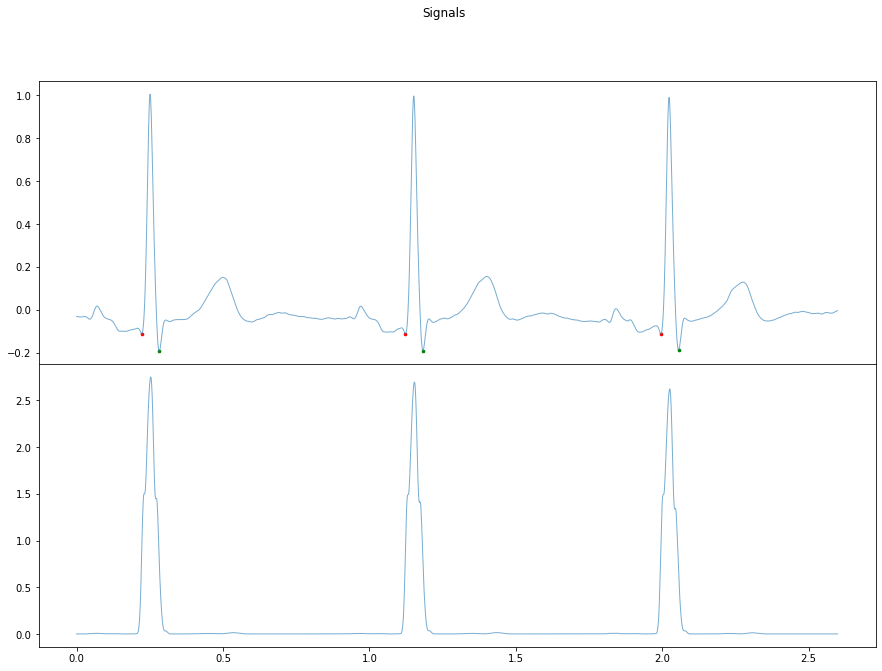

In [42]:
# Plot
ts = np.arange(0, time, 1.0 / fs)  # time vector

fig = plt.figure(figsize=[15, 10.4])
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle("Signals")
axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
axs[1].plot(ts, window_smoothed_signal, alpha=0.6, lw=1, label="SciPy lfilter")

axs[0].scatter(qx/fs, qy, color="red", s=7)
axs[0].scatter(sx/fs, sy, color="green", s=7)
#axs[0].scatter(Rx/fs, Ry, color="blue", s=7)

In [43]:
# 5. Thresholding (Get R, any value not the peak between Q and S is set to 0)
for i in range(len(qx)):
    y_lfiltered[qx[i]:sx[i]][y_lfiltered[qx[i]:sx[i]] != max(y_lfiltered[qx[i]:sx[i]])] = 0


print("Q: ")
print("-X: " + str(qx) + " - Y: " + str(qy))
print("S: ")
print("-X: " + str(sx) + " - Y: " + str(sy))
print(sx.shape)

# 6. Remove any peaks that are not Rs
y_lfiltered[y_lfiltered < max(y_lfiltered) * 0.7] = 0

# Retrieve R
Rx = []
Ry = []
for i in range(len(y_lfiltered)):
    if y_lfiltered[i] != 0:
        Rx.append(i)
        Ry.append(denoised_signal[i])

# Fix R (Crawl to correct value)
for i in range(len(Rx)):
    idx = Rx[i]
    while (True):
        if denoised_signal[idx-1] > denoised_signal[idx]:
            Rx[i] = idx-1
            Ry[i] = denoised_signal[idx-1]
        else:
            break
        idx -= 1
    idx = Rx[i]
    while (True):
        if denoised_signal[idx+1] > denoised_signal[idx]:
            Rx[i] = idx+1
            Ry[i] = denoised_signal[idx+1]
        else:
            break
        idx += 1

Rx = np.array(Rx)
Ry = np.array(Ry)

print("R:")
print("Rx: " + str(Rx) + " - Ry: " + str(Ry))

# Get QRS onset and offset
qrs_off_x = []; qrs_on_x = []
qrs_off_y = []; qrs_on_y = []
for x in Rx:
    X = np.array([x, window_smoothed_signal[x]])
    Y = np.array([x-300, window_smoothed_signal[x-300]])
    #print(X[1])
    #print(get_onset_offset(X, Y, window_smoothed_signal))
    qrs_on_x.append(get_onset_offset(X, Y, window_smoothed_signal))
    qrs_on_y.append(denoised_signal[qrs_on_x[len(qrs_on_x)-1]])
    
    Y = np.array([x+300, window_smoothed_signal[x+300]])
    qrs_off_x.append(get_onset_offset(X, Y, window_smoothed_signal))
    qrs_off_y.append(denoised_signal[qrs_off_x[len(qrs_off_x)-1]])

qrs_on_x = np.array(qrs_on_x); qrs_off_x = np.array(qrs_off_x)
qrs_on_y = np.array(qrs_on_y); qrs_off_y = np.array(qrs_off_y)

print("Qrs_on = " + str(qrs_on_x))

Q: 
-X: [ 222 1123 1996] - Y: [-0.11262226 -0.11310925 -0.11315076]
S: 
-X: [ 282 1183 2056] - Y: [-0.19362034 -0.19058844 -0.18706308]
(3,)
R:
Rx: [ 251 1152 2024] - Ry: [1.00393302 0.99573256 0.98946951]
Qrs_on = [ 210 1110 1982]


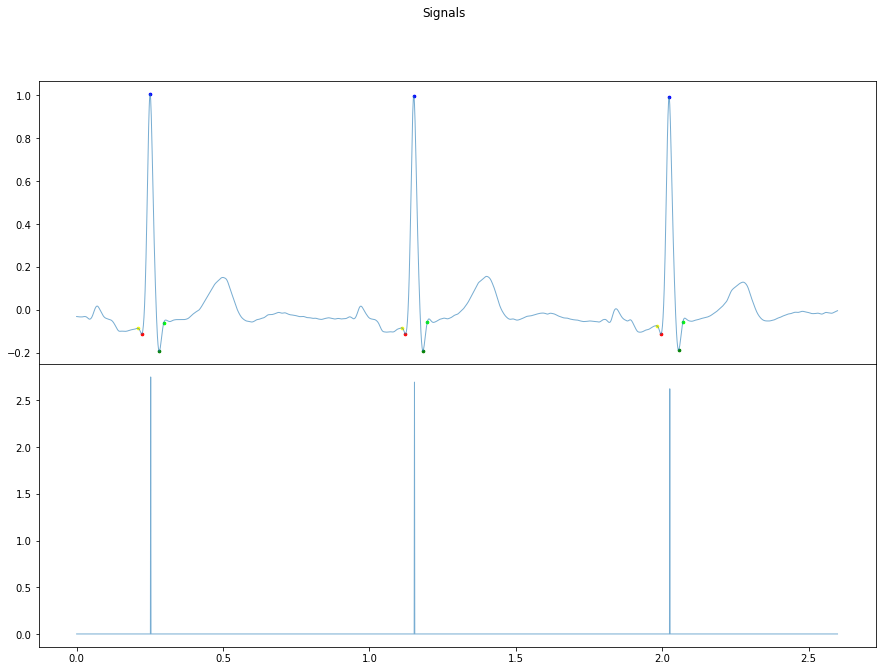

In [44]:
# Plot
ts = np.arange(0, time, 1.0 / fs)  # time vector

fig = plt.figure(figsize=[15, 10.4])
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle("Signals")
axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
axs[1].plot(ts, y_lfiltered, alpha=0.6, lw=1, label="SciPy lfilter")

axs[0].scatter(qrs_on_x/fs, qrs_on_y, color="yellow", s=7)
axs[0].scatter(qrs_off_x/fs, qrs_off_y, color="lime", s=7)
axs[0].scatter(qx/fs, qy, color="red", s=7)
axs[0].scatter(sx/fs, sy, color="green", s=7)
axs[0].scatter(Rx/fs, Ry, color="blue", s=7)

plt.show()

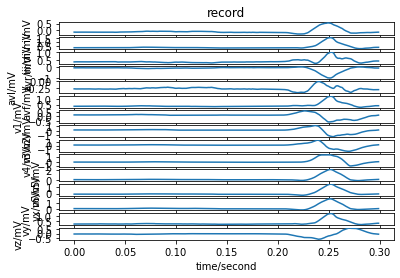

In [45]:
# Preview all channels
record = wfdb.rdrecord('../01.Dataset/117/s0291lre', sampfrom=samp_start, sampto=2300)
sample_rate = record.fs
wfdb.plot_wfdb(record, title='record')

In [46]:
print("Rx : " + str(Rx))
print("Ry : " + str(Ry))

Rx : [ 251 1152 2024]
Ry : [1.00393302 0.99573256 0.98946951]


In [47]:
print("QRS on : "+ str(qrs_on_x))
print("QRS off : "+ str(qrs_off_x))

QRS on : [ 210 1110 1982]
QRS off : [ 298 1198 2071]


In [48]:
# Get P wave
# Rx -> R peak location
window_size = int(fs * 0.2)  # 200 ms window
Px = []
Py = []

loc = qrs_on_x[0] # QRS onset
start_idx = int(loc - window_size)
#Py.append(max(denoised_signal[start_idx:loc])) # amplitude of P wave -> y value
#Px.append(np.argmax(denoised_signal[start_idx:loc])) # index of P wave -> x value

px = 0; py = -5
for i in range(start_idx,loc):
    if denoised_signal[i] > py:
        py = denoised_signal[i]
        px = i
print ("P wave: " + str(px) + " - " + str(py))
Py.append(py)
Px.append(px)

loc = qrs_on_x[1] # QRS onset
start_idx = int(loc - window_size)
#Py.append(max(denoised_signal[start_idx:loc])) # amplitude of P wave -> y value
#Px.append(np.argmax(denoised_signal[start_idx:loc])) # index of P wave -> x value

px = 0; py = -5
for i in range(start_idx,loc):
    if denoised_signal[i] > py:
        py = denoised_signal[i]
        px = i
print ("P wave: " + str(px) + " - " + str(py))
Py.append(py)
Px.append(px)

P wave: 70 - 0.017082204636948366
P wave: 971 - 0.016687702350284


In [49]:
print("Px : " + str(Px))
print("Py : " + str(Py))

Px : [70, 971]
Py : [0.017082204636948366, 0.016687702350284]


In [50]:
Px = np.array(Px)
Py = np.array(Py)

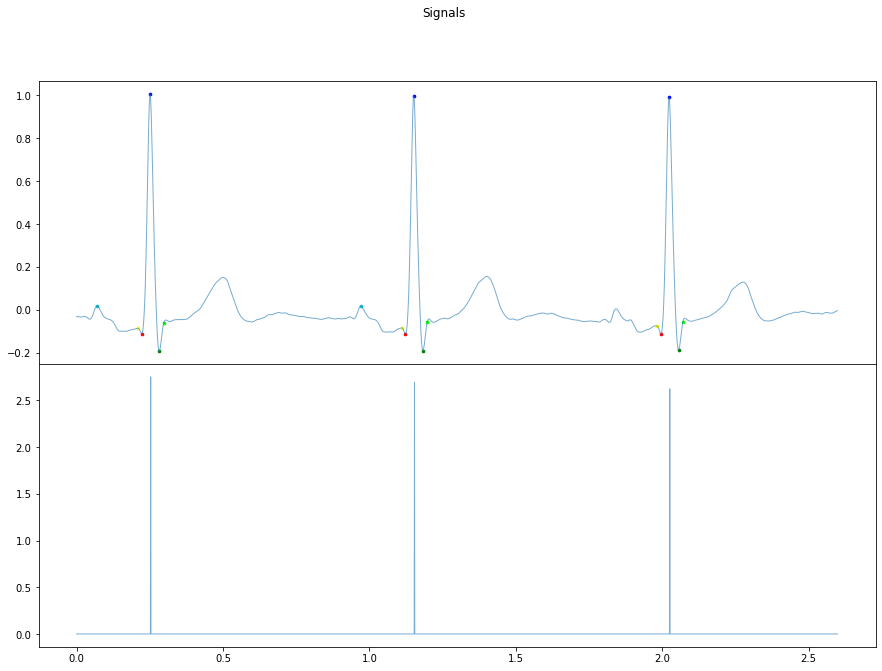

In [51]:
# Plot
ts = np.arange(0, time, 1.0 / fs)  # time vector

fig = plt.figure(figsize=[15, 10.4])
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle("Signals")
axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
axs[1].plot(ts, y_lfiltered, alpha=0.6, lw=1, label="SciPy lfilter")

axs[0].scatter(qrs_on_x/fs, qrs_on_y, color="yellow", s=7)
axs[0].scatter(qrs_off_x/fs, qrs_off_y, color="lime", s=7)
axs[0].scatter(qx/fs, qy, color="red", s=7)
axs[0].scatter(sx/fs, sy, color="green", s=7)
axs[0].scatter(Rx/fs, Ry, color="blue", s=7)
axs[0].scatter(Px/fs, Py, color="#17becf", s=7)

plt.show()

In [52]:
# Get P onset and offset
p_off_x = []; p_on_x = []
p_off_y = []; p_on_y = []

for x in Px:
    X = np.array([x, denoised_signal[x]])
    Y = np.array([x-window_size, denoised_signal[x-window_size]])
    #print(X[1])
    #print(get_onset_offset(X, Y, window_smoothed_signal))
    p_on_x.append(get_onset_offset(X, Y, denoised_signal))
    p_on_y.append(denoised_signal[p_on_x[len(p_on_x)-1]])
    
    Y = np.array([x+50, denoised_signal[x+50]])
    p_off_x.append(get_onset_offset(X, Y, denoised_signal))
    p_off_y.append(denoised_signal[p_off_x[len(p_off_x)-1]])

p_on_x = np.array(p_on_x)
p_off_x = np.array(p_off_x)
p_on_y = np.array(p_on_y)
p_off_y = np.array(p_off_y)

In [53]:
print("P onset : " + str(p_on_x) + " - " + str(p_on_y))
print("P offset : " + str(p_off_x) + " - " + str(p_off_y))

P onset : [ 45 947] - [-0.04387897 -0.04208139]
P offset : [ 95 998] - [-0.03503836 -0.03639055]


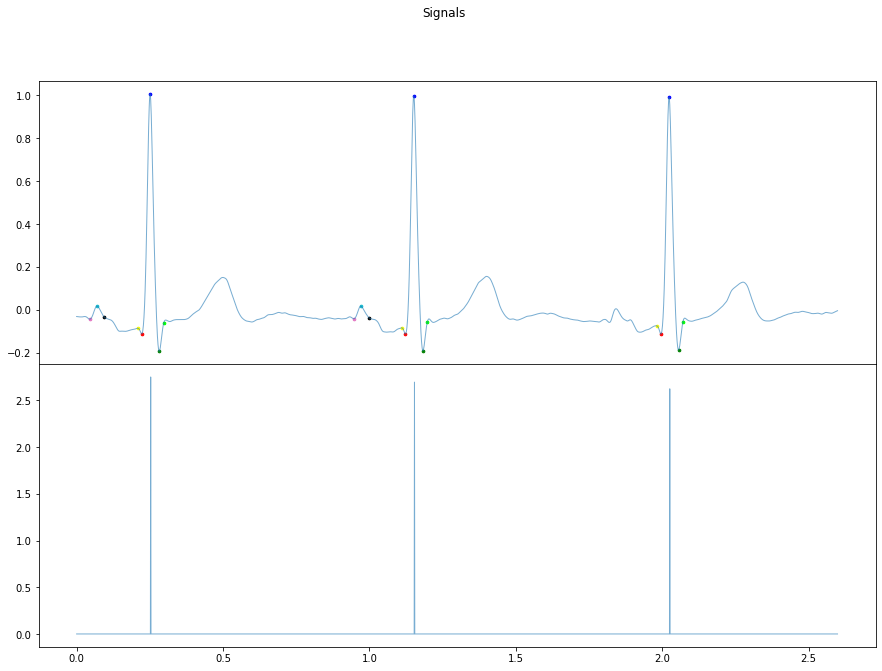

In [54]:
# Plot
ts = np.arange(0, time, 1.0 / fs)  # time vector

fig = plt.figure(figsize=[15, 10.4])
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle("Signals")
axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
axs[1].plot(ts, y_lfiltered, alpha=0.6, lw=1, label="SciPy lfilter")

axs[0].scatter(qrs_on_x/fs, qrs_on_y, color="yellow", s=7)
axs[0].scatter(qrs_off_x/fs, qrs_off_y, color="lime", s=7)
axs[0].scatter(qx/fs, qy, color="red", s=7)
axs[0].scatter(sx/fs, sy, color="green", s=7)
axs[0].scatter(Rx/fs, Ry, color="blue", s=7)
axs[0].scatter(Px/fs, Py, color="#17becf", s=7)
axs[0].scatter(p_on_x/fs, p_on_y, color="#e377c2", s=7)
axs[0].scatter(p_off_x/fs, p_off_y, color="black", s=7)

plt.show()

In [55]:
window_size = int(fs * 0.4)  # 400 ms window
print(window_size)

400


In [56]:
# Get T wave
# Rx -> R peak location
window_size = int(fs * 0.4)  # 200 ms window
Tx = []
Ty = []
ws = []
tx = 0; ty = 5
loc = qrs_off_x[0]+1 # QRS offset
start_idx = int(loc + window_size)
for i in range(loc , start_idx):
    w1 = denoised_signal[i-50] - denoised_signal[i]
    w2 = denoised_signal[i] - denoised_signal[i+50]
    w = w1 * w2
    if w < ty:
        ty = w
        tx = i
        
Tx.append(tx)
Ty.append(denoised_signal[tx])


tx = 0; ty = 5
loc = qrs_off_x[1]+1 # QRS offset
start_idx = int(loc + window_size)
for i in range(loc , start_idx):
    w1 = denoised_signal[i-50] - denoised_signal[i]
    w2 = denoised_signal[i] - denoised_signal[i+50]
    w = w1 * w2
    if w < ty:
        ty = w
        tx = i
Tx.append(tx)
Ty.append(denoised_signal[tx])

In [57]:
print("Tx : " + str(Tx))
print("Ty : " + str(Ty))

Tx : [498, 1399]
Ty : [0.15025003319748373, 0.15518055622247617]


In [58]:
Tx = np.array(Tx)
Ty = np.array(Ty)

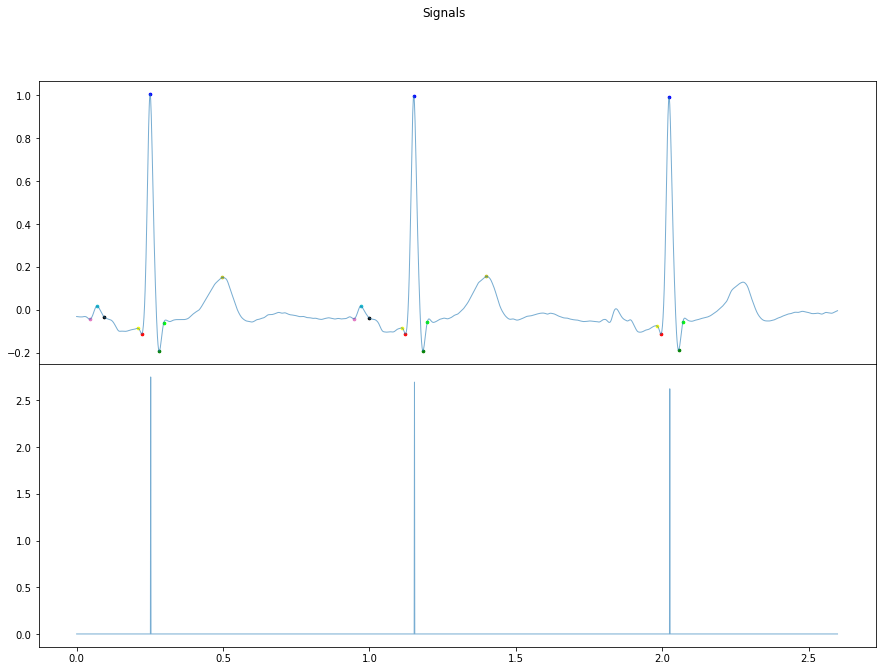

In [59]:
# Plot
ts = np.arange(0, time, 1.0 / fs)  # time vector

fig = plt.figure(figsize=[15, 10.4])
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle("Signals")
axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
axs[1].plot(ts, y_lfiltered, alpha=0.6, lw=1, label="SciPy lfilter")

axs[0].scatter(qrs_on_x/fs, qrs_on_y, color="yellow", s=7)
axs[0].scatter(qrs_off_x/fs, qrs_off_y, color="lime", s=7)
axs[0].scatter(qx/fs, qy, color="red", s=7)
axs[0].scatter(sx/fs, sy, color="green", s=7)
axs[0].scatter(Rx/fs, Ry, color="blue", s=7)
axs[0].scatter(Px/fs, Py, color="#17becf", s=7)
axs[0].scatter(p_on_x/fs, p_on_y, color="#e377c2", s=7)
axs[0].scatter(p_off_x/fs, p_off_y, color="black", s=7)
axs[0].scatter(Tx/fs, Ty, color="#bcbd22", s=7)

plt.show()

In [60]:
# Get T onset and offset
t_off_x = []; t_on_x = []
t_off_y = []; t_on_y = []

for x in Tx:
    X = np.array([x, denoised_signal[x]])
    Y = np.array([x-200, denoised_signal[x-200]])
    #print(X[1])
    #print(get_onset_offset(X, Y, window_smoothed_signal))
    t_on_x.append(get_onset_offset(X, Y, denoised_signal))
    t_on_y.append(denoised_signal[t_on_x[len(t_on_x)-1]])
    
    Y = np.array([x+200, denoised_signal[x+200]])
    t_off_x.append(get_onset_offset(X, Y, denoised_signal))
    t_off_y.append(denoised_signal[t_off_x[len(t_off_x)-1]])

t_on_x = np.array(t_on_x)
t_off_x = np.array(t_off_x)
t_on_y = np.array(t_on_y)
t_off_y = np.array(t_off_y)

In [61]:
print("T onset x : " + str(t_on_x))
print("T onset y : " + str(t_on_y))
print("T offset x : " + str(t_off_x))
print("T offset y : " + str(t_off_y))

T onset x : [ 383 1303]
T onset y : [-0.03845862 -0.01884309]
T offset x : [ 575 1475]
T offset y : [-0.04907358 -0.04178276]


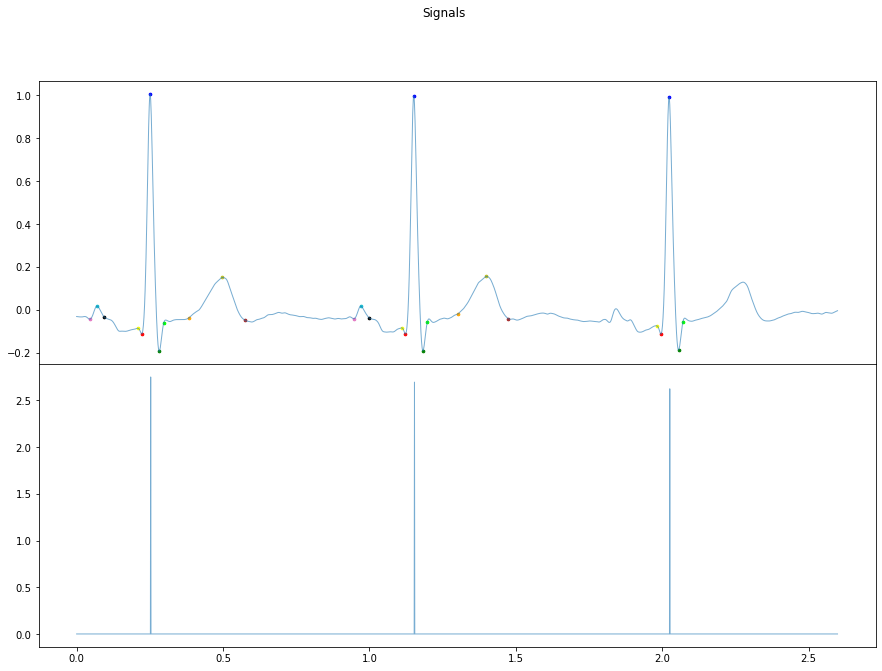

In [62]:
# Plot
ts = np.arange(0, time, 1.0 / fs)  # time vector

fig = plt.figure(figsize=[15, 10.4])
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle("Signals")
axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
axs[1].plot(ts, y_lfiltered, alpha=0.6, lw=1, label="SciPy lfilter")

axs[0].scatter(qrs_on_x/fs, qrs_on_y, color="yellow", s=7)
axs[0].scatter(qrs_off_x/fs, qrs_off_y, color="lime", s=7)
axs[0].scatter(qx/fs, qy, color="red", s=7)
axs[0].scatter(sx/fs, sy, color="green", s=7)
axs[0].scatter(Rx/fs, Ry, color="blue", s=7)

axs[0].scatter(Px/fs, Py, color="#17becf", s=7)
axs[0].scatter(p_on_x/fs, p_on_y, color="#e377c2", s=7)
axs[0].scatter(p_off_x/fs, p_off_y, color="black", s=7)

axs[0].scatter(Tx/fs, Ty, color="#bcbd22", s=7)
axs[0].scatter(t_on_x/fs, t_on_y, color="orange", s=7)
axs[0].scatter(t_off_x/fs, t_off_y, color="brown", s=7)

plt.show()

# Non Fiducial Feature 

In [88]:
RR_previous = Rx[1]-Rx[0]
RR_next = Rx[2]-Rx[1]

nonFiducial=[]

after_Rpeak = int (2/3*((RR_previous+RR_next)/2))

for i in range( int(Rx[1]) , int(Rx[1])+after_Rpeak) :
    nonFiducial.append( denoised_signal[i])

Before_Rpeak = int (1/3*((RR_previous+RR_next)/2))

for i in range(Before_Rpeak , int(Rx[1]) ):
    nonFiducial.append( denoised_signal[i])



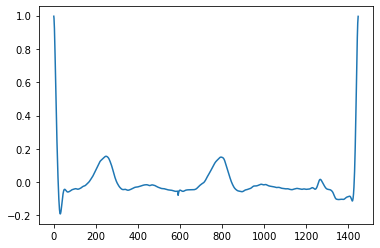

In [89]:
plt.plot(nonFiducial)

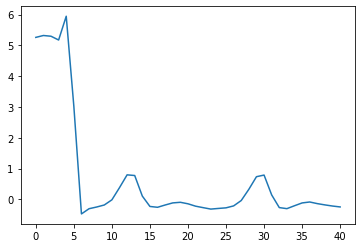

In [135]:
import pywt
import numpy as np

# Define the mother wavelet
wavelet = pywt.Wavelet('db4')

# Define the number of levels for decomposition
decomp_levels = 5

# Define the list of ECG signals
ecg_segments = np.array(nonFiducial)  # Example data

# Decompose the signal
decomp = pywt.wavedec(ecg_segments, wavelet, level=decomp_levels)

CA5,CD5,CD4,CD3,CD2,CD1 =decomp 

#only the coefficients of ECG band (1-40) use them as a feature 
non_fiducial_feature = CA5[:41]

plt.plot(non_fiducial_feature)